<a href="https://colab.research.google.com/github/ChenshuLiu/BE224B-Final-Project/blob/main/BE224B_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA

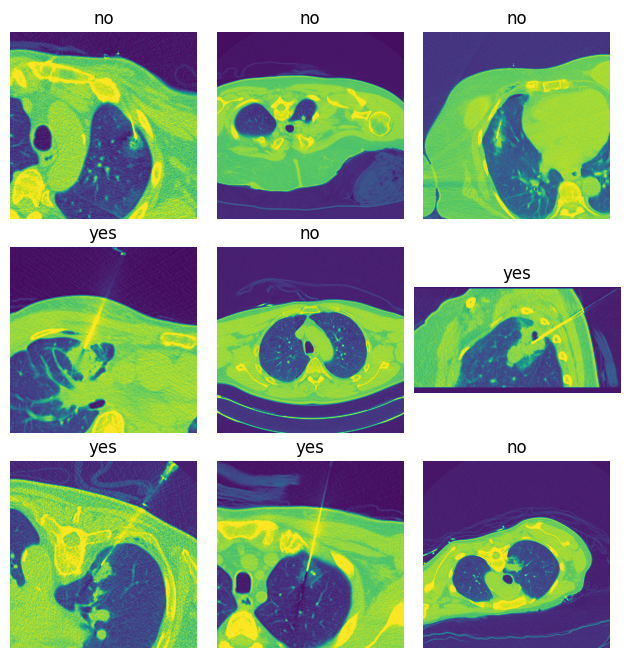

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

label_dir = '/content/drive/MyDrive/BE224B Final Project/Labels.csv'
img_dir = '/content/drive/MyDrive/BE224B Final Project/NeedleImages'

# Create a figure with 3x3 subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace = .15, wspace=.001)

label_df = pd.read_csv(label_dir)
for i in range(9):
  info = label_df.iloc[i]
  #print(label_df.iloc[i])
  img_title = info[1]
  img_path = os.path.join(img_dir, img_title)
  img = plt.imread(img_path, )

  # Get the corresponding label
  label = info[2]

  # Add the image and its label as a subplot
  ax = axs[i//3, i%3]
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(label)

plt.show()

# Labeling & Data Import

## Read in image label as dataframe

In [ ]:
import pandas as pd

label_dir = '/content/drive/MyDrive/BE224B Final Project/Labels.csv'
label_df = pd.read_csv(label_dir, index_col = 0)
label_df.head(5)

,Filename,Label
ID,,
0,20692.jpg,yes
1,20605.jpg,no
2,20600.jpg,yes
3,20594.jpg,yes
4,20588.jpg,no


## Separate images into respective folders
Separate single folder into two folders, for direct classification using the label of the folder

In [ ]:
from PIL import Image
import os
import numpy as np
import pandas as pd

ori_img_dir = '/content/drive/MyDrive/BE224B Final Project/NeedleImages'
sep_img_dir = '/content/drive/MyDrive/BE224B Final Project/NeedleImages_Labeled'
# set up counter for file naming
needle_counter = 0
noneedle_counter = 0

for index, row in label_df.iterrows():
  # retrieve image
  img_name = row['Filename']
  img_path = os.path.join(img_folder_dir, img_name)
  img = Image.open(img_path)

  if row['Label'] == 'yes': # when needle present
    file_name = f'needle_{needle_counter}.jpg'
    save_dir = os.path.join(sep_img_dir, 'Needle', file_name)
    img.save(save_dir)
    needle_counter += 1
  else: # when no needle present
    file_name = f'noneedle_{noneedle_counter}.jpg'
    save_dir = os.path.join(sep_img_dir, 'NoNeedle', file_name)
    img.save(save_dir)
    noneedle_counter += 1

## Label images according label dataframe

- images is a list that stores images as np.arrays (single channel) with size $512\times 512$
- labels is a list that stores labels

Running this typically takes a while (around 5 mins)

In [ ]:
import numpy as np
import os
from PIL import Image
from skimage.transform import resize

img_folder_dir = '/content/drive/MyDrive/BE224B Final Project/NeedleImages'
images = [] # store images
labels = [] # store corresponding labels

for index, row in label_df.iterrows():
  # retrieve image
  img_path = os.path.join(img_folder_dir, row['Filename'])
  img = Image.open(img_path)

  # convert image to array
  img_array = np.asarray(img)

  if img_array.shape != (512, 512):
    # rescale images to conform to 512*512
    scale_factor_h = 512/img_array.shape[0]
    scale_factor_w = 512/img_array.shape[1]
    img_array = resize(img_array,
                          (img_array.shape[0] * scale_factor_h,
                           img_array.shape[1] * scale_factor_w),
                          # prevent aliasing artifact
                          anti_aliasing=True)

  # save rescaled image to images and label to labels
  images.append(img_array)
  labels.append(row['Label'])

print(f"> There are {len(labels)} number of images and labels.")
print(f"> The data type for images in the list is {type(images[1])}.")
print(f"> The shape of the images are {images[1].shape}.")

> There are 632 number of images and labels.
> The data type for images in the list is <class 'numpy.ndarray'>.
> The shape of the images are (512, 512).


# Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Perform train-test split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print the sizes of train and test sets
print("Train set size:", len(train_images))
print("Test set size:", len(test_images))

Train set size: 505
Test set size: 127


In [28]:
import os
split_dir = '/content/drive/MyDrive/BE224B Final Project/Split_NeedleImages_Labeled'

for folder in os.listdir(split_dir):
  folder_dir = os.path.join(split_dir, folder)
  for subfolder in os.listdir(folder_dir):
    subfolder_dir = os.path.join(folder_dir, subfolder)
    num_files = len(os.listdir(subfolder_dir))
    print(f"The {subfolder} class in {folder} folder has {num_files} number of images.")

The NoNeedle class in Train folder has 154 number of images.
The Needle class in Train folder has 351 number of images.
The NoNeedle class in Test folder has 37 number of images.
The Needle class in Test folder has 90 number of images.


# Augmentation

In [ ]:
import torchvision.transforms as transforms

# Define your augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # Add more transformations as needed
])

# Apply augmentation to each training image
augmented_train_images = []
for image in train_images:
    augmented_image = train_transform(image)
    augmented_train_images.append(augmented_image)

# Classification

### Direct classification

#### Data Loader

In [32]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

data_root = '/content/drive/MyDrive/BE224B Final Project/Split_NeedleImages_Labeled'

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.Grayscale(), # load image as grayscale
    transforms.ToTensor(),  # Convert images to tensors
    # Add other transformations as needed
])

# Create ImageFolder datasets for train and test
train_dataset = ImageFolder(root=data_root + '/Train', transform=transform)
for img, label in train_dataset:
  img.requires_grad = True
test_dataset = ImageFolder(root=data_root + '/Test', transform=transform)
for img, label in test_dataset:
  img.requires_grad = True

# Set batch size for training and testing
batch_size = 8

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Modeling

##### Model Architecture

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import ExponentialLR
from torchsummary import summary
import numpy as np

pretrained_model = models.resnet152(pretrained = 'imagenet')
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size = 7,
                                   stride = 2, padding = 3, bias = False)

pretrained_lastfc = pretrained_model.fc.in_features

for param in pretrained_model.parameters():
  param.requires_grad = False

custom_classifier = nn.Sequential(
  nn.Linear(pretrained_lastfc, 256),
  nn.ReLU(),
  nn.Linear(256, 128),
  nn.ReLU(),
  nn.Linear(128, 64),
  nn.ReLU(),
  nn.Linear(64, 2)
)

pretrained_model.fc = custom_classifier
pretrained_model.to('cuda')

#print(pretrained_model)
summary(pretrained_model, input_size = (1, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

##### Training

In [46]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(pretrained_model.parameters(), lr = 0.001, momentum = 0.9)
optimizer = optim.SGD(pretrained_model.parameters(), lr = 0.1)
scheduler = ExponentialLR(optimizer, gamma = 0.5)

# parameters
patience = 10
best_loss = float('inf') # early stopping loss criteria
best_accuracy = 0 # early stopping accuracy criteria
counter = 0 # counter for patience during early stopping check
num_epochs = 100

val_accuracy = []
val_loss = []

for epoch in range(num_epochs):
  pretrained_model.train()
  running_loss = 0.0
  num_batches = 0
  for images, labels in train_loader:
    images = images.to('cuda')
    labels = labels.to('cuda')
    outputs = pretrained_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    optimizer.zero_grad()

  # Evaluate the model on the test set
  pretrained_model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0.0
    for images, labels in test_loader:
      images = images.to('cuda')
      labels = labels.to('cuda')
      outputs = pretrained_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      loss = criterion(outputs, labels)
      total_loss += loss.item()
      num_batches += 1

  accuracy = correct / total
  val_accuracy.append(accuracy)
  validation_loss = total_loss / num_batches
  val_loss.append(validation_loss)

  # early stopping
  if loss < best_loss or accuracy > best_accuracy:
    best_loss = loss
    best_accuracy = accuracy
    counter = 0
  else: # loss not further reducing
    counter += 1 # updating patience epoch

  if counter >= patience:
    break

  print(f"Epoch {epoch+1}/{num_epochs}, Running Loss: {running_loss:.4f}, Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}, Lr: {optimizer.param_groups[0]['lr']}")
  # update learning rate (Exp decay)
  scheduler.step()

Epoch 1/100, Running Loss: 39.3117, Validation Loss: 2.0279, Validation Accuracy: 0.7087, Lr: 0.1
Epoch 2/100, Running Loss: 33.5659, Validation Loss: 1.4484, Validation Accuracy: 0.7323, Lr: 0.05
Epoch 3/100, Running Loss: 32.1556, Validation Loss: 1.3592, Validation Accuracy: 0.7323, Lr: 0.025
Epoch 4/100, Running Loss: 30.6764, Validation Loss: 0.2771, Validation Accuracy: 0.6063, Lr: 0.0125
Epoch 5/100, Running Loss: 30.6268, Validation Loss: 0.8918, Validation Accuracy: 0.7402, Lr: 0.00625
Epoch 6/100, Running Loss: 29.1694, Validation Loss: 0.7753, Validation Accuracy: 0.7244, Lr: 0.003125
Epoch 7/100, Running Loss: 28.7974, Validation Loss: 0.9116, Validation Accuracy: 0.7402, Lr: 0.0015625
Epoch 8/100, Running Loss: 28.7281, Validation Loss: 0.9126, Validation Accuracy: 0.7559, Lr: 0.00078125
Epoch 9/100, Running Loss: 28.3152, Validation Loss: 0.8730, Validation Accuracy: 0.7402, Lr: 0.000390625
Epoch 10/100, Running Loss: 27.7961, Validation Loss: 0.8818, Validation Accuracy:

##### Training Result Viz

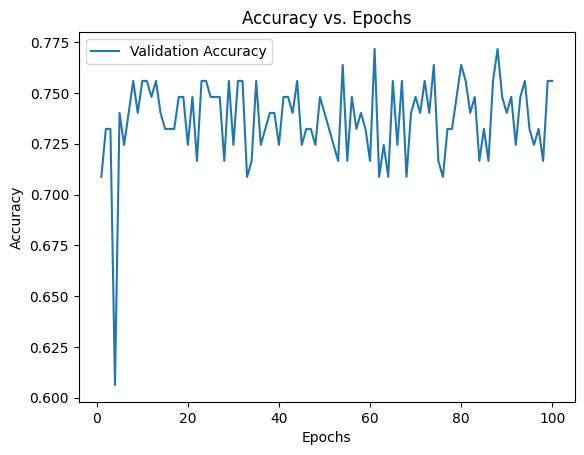

In [50]:
from matplotlib import pyplot as plt

# Create a list of epochs for the x-axis
epochs = range(1, len(val_accuracy) + 1)

# Plot the validation accuracy
plt.plot(epochs, val_accuracy, label='Validation Accuracy')

# Set the labels and title of the plot
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

### Enumerate straight line filters

## FFT: spatial domain to frequency domain
Goal is to see if needle affects the frequency domain information in the scans

### Playground

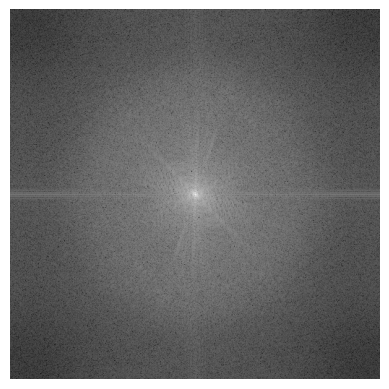

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert to grayscale
image = np.array(Image.open('/content/drive/MyDrive/BE224B Final Project/NeedleImages/10106.jpg').convert('L'))

# Pad the image with zeros
padded_image = np.pad(image, ((0, 512 - image.shape[0]), (0, 512 - image.shape[1])))

# Compute the Fourier Transform
freq_domain = np.fft.fft2(padded_image)
freq_domain = np.fft.fftshift(freq_domain)

# Compute the magnitude spectrum
magnitude_spectrum = np.abs(freq_domain)

# Visualize the magnitude spectrum
plt.imshow(np.log(1 + magnitude_spectrum), cmap='gray')
plt.axis('off')
plt.show()

### Batch FFT
Apply FFT for each of the images in NeedleImages folder

In [ ]:
import numpy as np

freq_images = []
for i, img in enumerate(images):
  # Pad the image with zeros
  padded_image = np.pad(img, ((0, 512 - img.shape[0]), (0, 512 - img.shape[1])))

  # Compute the Fourier Transform
  freq_domain = np.fft.fft2(padded_image)
  freq_domain = np.fft.fftshift(freq_domain)

  # append to the freq_images for storage
  freq_images.append(freq_domain)

  # status update
  if i % 100 == 0:
    print(f"Frequency domain information of first {i} images has been generated!")

Frequency domain information of first 0 images has been generated!
Frequency domain information of first 100 images has been generated!
Frequency domain information of first 200 images has been generated!
Frequency domain information of first 300 images has been generated!
Frequency domain information of first 400 images has been generated!
Frequency domain information of first 500 images has been generated!
Frequency domain information of first 600 images has been generated!


# Segmentation

## Canny Edge Detection